In [ ]:

%pip install -q -U gymnasium
%pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from IPython.display import HTML
from collections import deque
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop
from tensorflow.keras.losses import MSE
import random

Environment provides an observation consisting of a tuple representing the state of the game:
1. **Player's current hand sum:** An integer representing the sum of the player's cards.
2. **Dealer's visible card:** An integer showing the value of the dealer's face-up card.
3. **Usable ace:** A binary value (True or False) indicating whether the player has a usable ace (an ace that can be counted as 11 without busting).

(15, 2, 0)


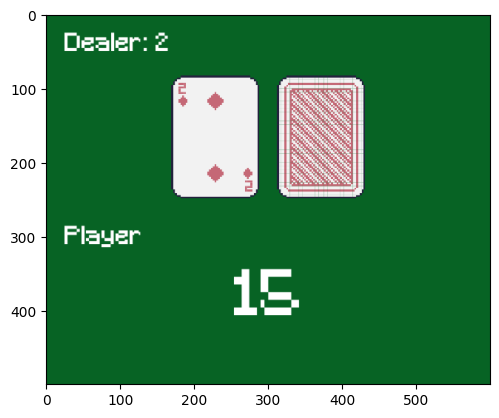

In [ ]:
env = gym.make("Blackjack-v1", natural=False, sab=False,render_mode = "rgb_array")
obs, info = env.reset(seed=42)
env.action_space.seed(42)
print(obs)
img = env.render()
plt.imshow(img)

The output indicates that the action space is discrete with two possible actions:
- **0:** Stick (hold your current hand and let the dealer play).
- **1:** Hit (take another card to increase the sum of your hand).

In [ ]:
env.action_space

Discrete(2)

Example action:

In [ ]:
action = 1  # 1 = Hit
obs, reward, done, truncated, info = env.step(action)


In [ ]:
print(obs)        # Observation (state of the game)
print(reward)     # Reward obtained from the action
print(done)       # Indicates if the game has ended
print(truncated)  # Indicates if the game was ended early (not typically used in Blackjack)
print(info)       # Additional information (usually empty in Blackjack)

(25, 2, 0)
-1.0
True
False
{}


In [ ]:
def basic_policy(obs): #player sticks whenever their card value is 17 or higher
    card_value = obs[0]
    if card_value >= 17:
        return 0
    else:
        return 1

In [ ]:
basic_win_count = 0
basic_loss_count = 0
basic_draw_count = 0

rewards = []
for game in range(1000):
    obs, info = env.reset(seed=game)
    for step in range(50):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
          if reward == 1:
            basic_win_count += 1
          elif reward == -1:
            basic_loss_count += 1
          else:
            basic_draw_count += 1

          rewards.append(rewards)
          break

The current policy, which sticks on a hand value of 17 or higher, yields a slightly negative average reward of -0.081 over 1000 games

In [ ]:
# Calculate win, loss, and draw percentages for basic policy
basic_win_percentage = (basic_win_count / 1000) * 100
basic_loss_percentage = (basic_loss_count / 1000) * 100
basic_draw_percentage = (basic_draw_count / 1000) * 100

print(f"Win percentage: {basic_win_percentage:.2f}%")
print(f"Loss percentage: {basic_loss_percentage:.2f}%")
print(f"Draw percentage: {basic_draw_percentage:.2f}%")

Win percentage: 41.20%
Loss percentage: 49.30%
Draw percentage: 9.50%


In [ ]:
input_shape = [3]
n_outputs = 2
model = Sequential([
    Input(shape=input_shape),
    Dense(32, activation = "elu"),
    Dense(32, activation = "elu"),
    Dense(n_outputs)
])

**Epsilon-greedy policy** - standard approach in reinforcement learning to balance exploration and exploitation: If epsilon is high (e.g., 0.5), the function would often choose random actions to explore different outcomes. If epsilon is low (e.g., 0.1), it would mostly choose the action with the highest predicted Q-value, favoring exploitation of the learned strategy

In [ ]:
def epsilon_greedy_policy(state, epsilon = 0):      #choose random action with probability epsilon, otherwise choose best
    if np.random.rand() < epsilon:                  #generates a random float between 0 and 1
        return np.random.randint(n_outputs)         #random action
    else:
        state = np.array(state)
        Q_values = model.predict(state[np.newaxis], verbose = 0)[0]
        return Q_values.argmax()

Once the deque reaches this limit, the oldest entries are automatically removed when new entries are added. This prevents the buffer from growing indefinitely and consuming too much memory. The buffer is used to store experience tuples. Each experience typically consists of: State, Action, Reward, Next State, Done, Truncateds.

**Deep Q-Network:**

1. Each time the agent interacts with the environment, a new experience is added to the replay buffer.
2. During training, a batch of experiences is randomly sampled from the buffer to train the neural network, helping the agent learn a more general policy.

In [ ]:
replay_buffer = deque(maxlen=2000)

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
    #return a list of six numpy arrays, each representing one component of the experiences in the batch:
    #states, actions, rewards, next_states, dones, truncateds.

This function performs a single step in the environment, selecting an action using an epsilon-greedy policy, interacting with the environment, and storing the experience in the replay buffer.

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [ ]:
batch_size = 64
losses = []
#The discount factor (γ) used in the Q-learning update formula. It determines how much future rewards are considered.
#A value close to 1 means future rewards are highly valued, while a value closer to 0 means immediate rewards are prioritized.
discount_factor = 0.99
optimizer = Adam(learning_rate = 0.001)
loss_fn = MSE

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose = 0)                         # predict the Q-values for each action in each of the next_states
    max_next_Q_values = next_Q_values.max(axis=1)                                   # selects the highest Q-value for each next_state
    runs = 1.0 - (dones | truncateds)                                               # ignore future Q-values for states where the episode has ended (1 - episode is still running, 0 - episode has ended.)
    target_Q_values = rewards + runs*discount_factor*max_next_Q_values              # calculat the target Q-values using the Bellman equation
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)                                           # ensures that only the Q-value corresponding to the chosen action is selected
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))                   # These extracted Q-values are then compared with the target Q-values (calculated using the Bellman equation) to compute the loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    losses.append(loss.numpy())

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
env.action_space.seed(42)

win_count = 0
loss_count = 0
draw_count = 0
rewards = []
best_average_reward = 0
best_weights = None

for game in range(1000):
    obs, info = env.reset()
    final_reward = 0
    for step in range(200):
        epsilon = max(1-game/500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done:
          final_reward = reward
          break

    print(f"\rGame: {game + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(final_reward)

    if final_reward == 1:
        win_count += 1
    elif final_reward == -1:
        loss_count += 1
    else:
        draw_count += 1

    # calculate the average reward over the last 50 games
    # and save the model's weights if the average is greater than the best average reward
    if (game + 1) % 50 == 0:
        average_reward = np.mean(rewards[-50:])
        if average_reward > best_average_reward:
            best_average_reward = average_reward
            best_weights = model.get_weights()
            print(f"\nSaved weights at game {game + 1}")
    
    # Begin training the model after 200 games to allow for enough experiences to be collected
    if game > 200:
        training_step(batch_size)

Game: 650, Steps: 2, eps: 0.010
Saved weights at game 650
Game: 750, Steps: 1, eps: 0.010
Saved weights at game 750
Game: 1000, Steps: 1, eps: 0.010

In [ ]:
model.set_weights(best_weights)

In [ ]:
# Calculate win, loss, and draw percentages
win_percentage = (win_count / 1000) * 100
loss_percentage = (loss_count / 1000) * 100
draw_percentage = (draw_count / 1000) * 100

print(f"Win percentage: {win_percentage:.2f}%")
print(f"Loss percentage: {loss_percentage:.2f}%")
print(f"Draw percentage: {draw_percentage:.2f}%")

Win percentage: 39.50%
Loss percentage: 54.10%
Draw percentage: 6.40%


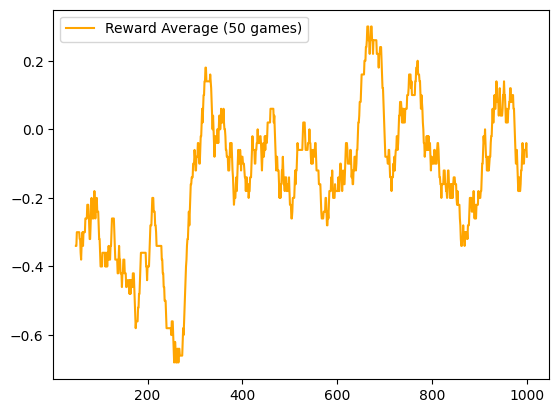

In [ ]:
window = 50
games_avg_rewards = np.convolve(rewards, np.ones(window) / window, mode='valid')
plt.plot(range(window - 1, len(rewards)), games_avg_rewards, color="orange", label="Reward Average (50 games)")
plt.legend()
plt.show()

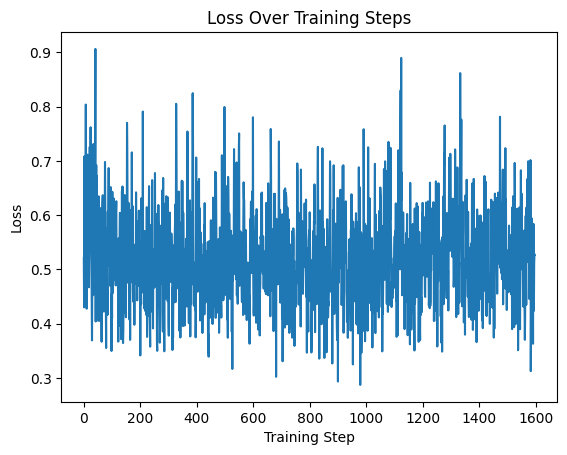

In [ ]:
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Over Training Steps")
plt.show()

Plotting Win, Loss and Draw Rates

Results after 100 test games:
Win percentage: 36.00%
Loss percentage: 48.00%
Draw percentage: 16.00%


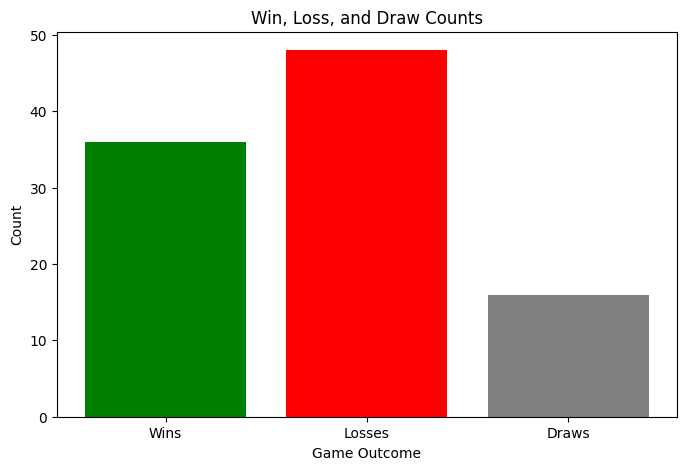

In [ ]:
env.reset(seed=42)

def test_model(env, model, n_games=100):
    win_count = 0
    loss_count = 0
    draw_count = 0
    rewards = []

    for game in range(n_games):
        obs, info = env.reset()
        done = False
        final_reward = 0

        while not done:
            # Use the trained model to select the best action (epsilon = 0)
            action = epsilon_greedy_policy(obs, epsilon=0)
            obs, reward, done, truncated, info = env.step(action)

            if done:
                final_reward = reward  # Final reward determines the result
                break

        rewards.append(final_reward)

        if final_reward == 1:
            win_count += 1
        elif final_reward == -1:
            loss_count += 1
        else:
            draw_count += 1

    # Calculate win, loss, and draw percentages
    win_percentage = (win_count / n_games) * 100
    loss_percentage = (loss_count / n_games) * 100
    draw_percentage = (draw_count / n_games) * 100

    print(f"Results after {n_games} test games:")
    print(f"Win percentage: {win_percentage:.2f}%")
    print(f"Loss percentage: {loss_percentage:.2f}%")
    print(f"Draw percentage: {draw_percentage:.2f}%")

    labels = ['Wins', 'Losses', 'Draws']
    counts = [win_count, loss_count, draw_count]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color=['green', 'red', 'gray'])
    plt.xlabel('Game Outcome')
    plt.ylabel('Count')
    plt.title('Win, Loss, and Draw Counts')
    plt.show()

test_model(env, model)

**Results and Experiments**

We experimented with different optimizers and learning rates to try and improve the model.


*   **RMSProp** - the optimizer was chosen as it can handle the variability of data in the Blackjack game by adjusting the learning rate adaptively. Even though this performed better than other optimizers, higher performance could be achived.


*   **NAdam** - was chosen as it combines the adaptive learning rate that Adam provides with the Nesterov momentum, which offers an additional benefit by looking “ahead” in the direction of the gradient before making an update. This however produced worse results than simply using Adam.


*   **Adam** - the optimizer seems to perform the best in our case. It resulted in 39.5% win rate while training 1000 episodes and 36% win rate when testing the model.




